# Prédiction de la présence en utilisant un réseau de neurones

Ce notebook a comme but de montrer ce qu'un réesau de neurones artificiels peut faire face à notre problème.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.metrics import FalseNegatives, Recall
from tensorflow.keras.models import Sequential

## Préparation des données

In [2]:
# Load the data
file_path = '../../data/processed/processed_enhanced_data_with_presence.csv'

df = pd.read_csv(file_path)
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))
gdf.set_crs(epsg=2056, inplace=True)
gdf.set_index("idx", inplace=True)

gdf.head()

,geometry,Altitude,NaturalHabitat,SoilType,WaterRetention,NutrientContent,WaterPermeability,Temperature,Presence,Count
idx,,,,,,,,,,
35,"POLYGON ((2485071.58 1109261.72, 2486071.58 11...",363.5148,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2,0,0
36,"POLYGON ((2485071.58 1110261.72, 2486071.58 11...",358.9348,62.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.2,0,0
261,"POLYGON ((2486071.58 1109261.72, 2487071.58 11...",415.6684,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3,0,0
262,"POLYGON ((2486071.58 1110261.72, 2487071.58 11...",368.5936,62.0,"eutric, dystric Cambisol; eutric Regosol; spod...",4.0,4.0,4.0,5.3,0,0
263,"POLYGON ((2486071.58 1111261.72, 2487071.58 11...",352.9472,82.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,5.3,0,0


In [3]:
# Separate the features and target
X = gdf.drop(
    columns=["Presence", "Count", "geometry", "SoilType"]
)  # Drop non-feature columns
y = gdf["Presence"].to_numpy()

# Normalize the bootstrapped features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Création du modèle

In [4]:
def init_model():
    model = Sequential(
        [
            Input(shape=(X_scaled.shape[1],)),
            Dense(8, activation="relu"),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        optimizer="Adam",
        loss="MSE",
        metrics=[
            Recall(),
            FalseNegatives(),
        ],
    )
    return model

## Évaluation du modèle

In [5]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Store metrics for each fold
fold_metrics = []

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.unique(y_train), y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))

    model = init_model()

    # Train the model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        class_weight=class_weight_dict,
        verbose=0,
    )

    # Evaluate on test set
    y_pred_proba = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    fold_metrics.append(
        {"roc_auc": roc_auc, "precision": precision, "recall": recall, "f1": f1}
    )

# Display average performance
print("Cross-Validation Results:")
print(pd.DataFrame(fold_metrics).mean())

Cross-Validation Results:
roc_auc      0.756147
precision    0.131720
recall       0.825755
f1           0.227061
dtype: float64


Le *recall* est la métrique qui nous intéresse le plus car les faux positifs nous interessent moins que les faux négatifs.

In [6]:
# Predict probabilities for the entire dataset
gdf["predicted_proba"] = model.predict(scaler.transform(X), verbose=0).flatten()

In [7]:
def visualize_predictions(gdf, predicted_col="predicted_proba", threshold=0.5):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Probabilities
    gdf.plot(column=predicted_col, cmap="YlGnBu", legend=True, ax=ax[0], scheme="quantiles")

    ax[0].set_title("Predicted Probabilities", fontsize=14)
    ax[0].set_axis_off()

    # Binary classification map
    gdf["binary_pred"] = (gdf[predicted_col] >= threshold).astype(int)

    gdf.plot(column="binary_pred", cmap="plasma", legend=True, ax=ax[1], categorical=True)
    
    ax[1].set_title(f"Binary Classification (Threshold = {threshold})", fontsize=14)
    ax[1].set_axis_off()
    
    plt.show()

Voici les prédictions sous le forme de deux graphiques, le premier sépare les probabilités en intervalles et le deuxième nous montre la classification binaire avec un seuil de probabilité pour séparer en deux, 0.6 nous donne des bons résultats.

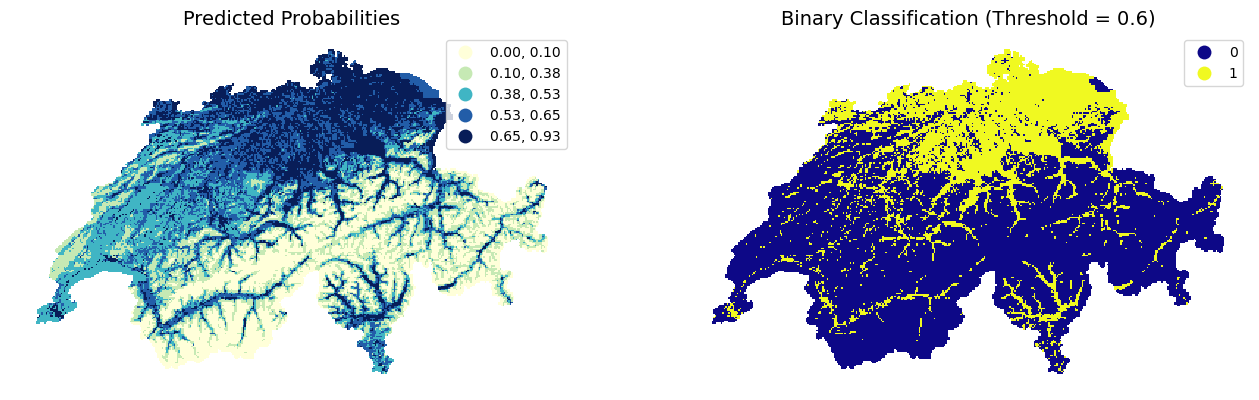

In [8]:
visualize_predictions(gdf, threshold=0.6)

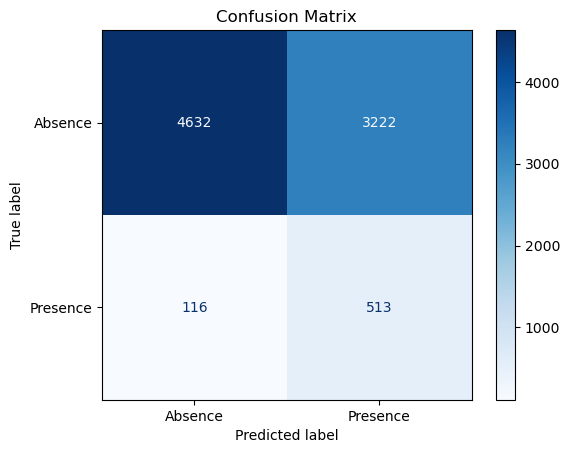

In [9]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Convert probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int)

# Compute and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Absence", "Presence"]
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Notre modèle prédit bien les absences mais a plus de peine à prédire les présences